### INF 510 FINAL PROJECT
##### Name: Peter Argo
##### submit: 12/13/19

**1. The names of team member(s)**

Peter Argo

**2. How to run your code (what command-line switches they are, what happens when you invoke the code, etc.)**

First clone the repo in the GitHub repository. Execute each cell in this notebook. It is structured in 5 major section that are clearly labeled within the notebook. The MLB_function.py file contains all the required functions and is imported on the first step of the project.  Two .csv files stored in subdirectory “data” are also required.  Additionally, the following packages are needed:

- pandas, numpy, os, requests, re, collections, csv, sklearn, pprint, time, and beautifulsoup

**3. Any major “gotchas” to the code (i.e. things that don’t work, go slowly, could be improved, etc.)**

Surprisingly, I could not find many MLB API’s that provided useful information within the scope of my project. I believe I creatively exercised the utility of the MLB API contained in my project however in order to scrape for all the data, I takes much longer to process then is ideal.  See the "read this" section below for tips on processing this

**4. Anything else you feel is relevant to the grading of your project your project.** 

It was a challenge to make the code robust and efficient at the area of the API data scraping because o fhow much time it too to get the data. I tried to make it as efficient as possible by limiting the number of inputs and lines processed but it does have to pull quite a bit of data and process it to get anything relevant. With time I would optimize the algorithm to reduce the amount of time it takes to process the API data.  The API data redundantly pulls data which is done because of how it iterated through the input team data structure. This could be mitigated with more time  

**5. What did you set out to study? (i.e. what was the point of your project? This should be close to your Milestone 1 assignment, but if you switched gears or changed things, note it here.)** 

The original intent was to evaluate which MLB team regular season stats had the greatest impact on predicting the teams success in the playoffs. Originally, I wanted to do some method of multi-class evaluation where each team was assigned a score for how far they advanced in the playoffs. However, I slightly deviated from this premise to look at each postseason series individually and assign a binary classification of “win” or “not win” in order to analyze the team stats data. The project slightly evolved as I gained greater understanding of how to analyze everything and ultimateky did a logistic regression to determine the win probability the team with the better record has of wining their postseason series given the selected regular season features data. 

I also pivoted from one of my data sources detailed in milestone 1 because earlier on I ran into trouble extracting the data from the initially proposed webpage and due to time constraints, had to move on.  Only after making significant progress on the new data source (fox sports) did I finally discover what my issue was with my old data source. At this point it was too late to go back. The content was largely the same.


**6. What did you Discover/what were your conclusions (i.e. what were your findings? Were your original assumptions confirmed, etc.?)**

I believe the results were mostly in line with what was expected.  I suspected that if I were to successfully be able to complete this project that I would perhaps get some quasi-favorable results, however given the time constraint and limitations with the data size, no real conclusions should be deduced.  I was under no delusion that I would be able to forecast games with any statistically significant reliability.  However, I was hoping to demonstrate the logic behind this process and hopefully have a result to discuss at the end.

Ultimately, I got a result that was better than expected but it certainly fluctuated with how I partition my test set and training set. 20% - 30% test size seemed reasonable for this project. I was fortunate that this yielded a positive model. Bottom line: I now expect to win big money betting on MLB postseason series! 


**7. What difficulties did you have in completing the project?**

Scraping the data and formatting the data in a logical manner to be able to manipulate efficiently took about 80% of my time and attention. This was challenging but about as much as anticipated.  The machine learning took less time and was less coding intensive, but it was more esoteric. From a macro perspective, I knew how the statistical analysis should be performed. But when executing the analysis, I had difficulty understanding what the target value should be and how to set up the features for each team in each postseason series.  I came up with a few different approaches after much deliberating but felt that none of them were as comprehensive and insightful as I had hoped. I wanted to make the target value to be a binary classification of “home team win” vs. “home team not win” but I could not get this from my data sources. This would present a clean way to analyze the data and provide a logical paradigm to compare results (assuming the home team wins slightly more than the road team).  I also had difficulties in setting up the features because I had features for two teams and a classifier for the series.  Ultimately, I reasoned to take the difference of the two values, creating a statistical profile for the series itself. Lastly, my binary classifier was “team with better record win” vs. “team with better record not win”. This seemed to be a reasonable choice but I primarily chose this because it was scrapable from my data sources.


**8. What skills did you wish you had while you were doing the project?**

I wish I was sounder in my statistics background. I was disappointed in the challenges I was running into when completing this analysis. I understood the machine learning topics in a meta perspective but the execution left a lot to be desired.

**9. What would you do “next” to expand or augment the project?**

The obvious improvement would be to play around with the statistics that I chose and see which permutation of team stats yielded the best results for my analysis. It reasons that simply, more data would be better but some baseball statistics have a lot of overlapping information (batting avg vs. on base percentage for example).  I would also expand the types of analyses beyond just logistic regression and determine which method yielded the best results. Lastly, I would most need to expand my training and test set. Baseball is fundamentally the most probabilistic of the major American sports and thus would likely require the most data to reduce the noise. It might be advantageous to look at every game played individually instead of the entire postseason series as one datapoint. This would require many more data sources. 


# --------------------------------------------------------------------------------------------------------------|

Overview:
<br>
The goal is to evaluate which MLB regular season team statistics predicted success of teams in the postseason
<br>
This notebook shall scrape data from the following 3 sources:
<br>
1. Baseball reference
<br>
2. Fox Sports
<br>
3. MLB API
<br>
This notebook shall format the data using SQL and Pandas as primary methods
<br>
This Notbook shall analyze the data using a logistic regression to draw conclusions

First we need to import all modules used to do our analysis. Importing MLB_functions initializes the function contained within and creates our database and tables used to store data. 
<br>
Important note: If you want to re-initialize the tables, you must restart the kernal and import the MLB_functions again as this is where the database is orginally generated

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import sys
sys.path.insert(0, os.path.abspath("C:\\Users\\Peter Argo\\Desktop\\INF 510\\Project\\src"))
from MLB_functions import *
import MLB_functions
import requests
import re
import time
import csv
import collections
import pprint
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm, datasets
# from sklearn.metrics import plot_confusion_matrix

### Section 1: Extract post season series from Baseball Reference

function baseball_ref_scraper gets the data from baseball reference
the data are arrays containing the year the winner, the loser, and the title of each series as well as a booloen 
determining if the team with more reg season wins won and a cnt value of times a series was played by team with 
the same number of regular season wins.
The value input into baseball_ref_scraper determines the number of post season series that we want to analyse
value must be less or equal to than 190

***READ THIS***
<br>
This will be more clear as you walk through the notebook, however I reccomend inputing 190 for the number_of_series (maximum possible value.  This will show its robustness. Then execute every cell until you get to Section 3 (API data  extract section). Skip Section 3. Then run all cells in section 4 (Analysis 1 of 2). This will provide the logic used throughout using the largest dataset possible.
<br>
<br>
Subsequently, restart the kernal. Import the above module to reintialize our database. Then Run through the entire notbook as layed out however I would not input a number greater than 25 for number_of_series. The API scraper requires much processing and thus larger numbers take significantly more time to scrape for the data.

In [2]:
number_of_series = int(input("input a value below 191:"))
while number_of_series > 190:
    number_of_series = int(input("please provide a value lower than 191. Thanks!:"))
print(f"you chose: {number_of_series}")

input a value below 191:190
you chose: 190


In [3]:
(year, winning_team_array, losing_team_array, postseason_series, more_wins, cnt) = baseball_ref_scraper(number_of_series)

# print valuse to visualize output if needed

# print(winning_team_array)
# print('\n')
# print(losing_team_array)
# print('\n')
# print(postseason_series)
# print('\n')
# print(year)
# print('\n')
# print(more_wins)
# print('\n')
# print(cnt)

The number of times the team with the winning record wins their postseason series is determined to be approx 50% if the time. The number of times there were equal wins between the competing times was not considered in this calculation. Therefore if you be bet squarely on number of wins a team has vs the opposing team, you could expect to win approximatly half the time. Using wins as our target, we want to improve on these odds.

In [4]:
counter=collections.Counter(more_wins)
print(f"the percent of series where the team with the better record advanced is {counter[1]/(counter[0]+counter[1]-cnt)*100}% for this sample")

the percent of series where the team with the better record advanced is 49.72067039106145% for this sample


Create the Primary Key database
<br>
Requires input .csv file from Data subdirectory

In [5]:
val_prim = []
with open('..\data\MLB teams.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for line in csv_reader:
        line[0] = int(line[0])
        line[3] = int(line[3])
        val_prim.append((line[0],str(line[1]),str(line[2]),line[3]))

sql_prim = 'INSERT INTO prim_ID (team_id, team_city, team_name, API_ID) VALUES (?, ?, ?, ?)'

cur.executemany(sql_prim,val_prim)

cur.execute('SELECT * FROM prim_ID')
results = cur.fetchall()
print(results)

[(1, 'Arizona', 'Diamondbacks', 109), (2, 'Atlanta', 'Braves', 130), (3, 'Baltimore', 'Orioles', 110), (4, 'Boston', 'Red Sox', 111), (5, 'Chicago_', 'Cubs', 112), (6, 'Chicago', 'White Sox', 145), (7, 'Cincinnati', 'Reds', 113), (8, 'Cleveland', 'Indians', 114), (9, 'Colorado', 'Rockies', 115), (10, 'Detroit', 'Tigers', 116), (11, 'Houston', 'Astros', 117), (12, 'Kansas City', 'Royals', 118), (13, 'Los Angeles', 'Angels', 108), (14, 'Los Angeles_', 'Dodgers', 119), (15, 'Miami', 'Marlins', 146), (16, 'Milwaukee', 'Brewers', 158), (17, 'Minnesota', 'Twins', 142), (18, 'New York', 'Mets', 121), (19, 'New York_', 'Yankees', 147), (20, 'Oakland', 'Athletics', 133), (21, 'Philadelphia', 'Phillies', 143), (22, 'Pittsburgh', 'Pirates', 134), (23, 'San Diego', 'Padres', 135), (24, 'San Francisco', 'Giants', 137), (25, 'Seattle', 'Mariners', 136), (26, 'St. Louis', 'Cardinals', 138), (27, 'Tampa Bay', 'Rays', 139), (28, 'Texas', 'Rangers', 140), (29, 'Toronto', 'Blue Jays', 141), (30, 'Washing

Creater Database for each postseason series winning team and losing team
(series, winning team, losing team, year, winning team won Boolean)

In [6]:
sql_series = 'INSERT INTO Series (postseason_series, winning_team, losing_team, year, WTW) VALUES (?, ?, ?, ?, ?)'
val_series = []
counter = 0
for i in range(len(winning_team_array)):
    val_series.append((postseason_series[i], MLB_functions.read_from_db(winning_team_array[i]), MLB_functions.read_from_db(losing_team_array[i]),year[i],more_wins[i]))
    counter += 1
cur.executemany(sql_series,val_series)

cur.execute('SELECT * FROM Series')
results = cur.fetchall()
# print(results)

### Section 2: Extract team statistics from Fox Sports
##### Collect hitting and pitching stats for each team. Web scrape FOX sports page

Mine data from fox sports. Store the data in the team_stats database, stats table

In [17]:
# Request pitching data from fox sports
my_years = []
my_yr = 2019 # enter the current year or any year that you want to start collecting data from
while my_yr >= min(year):
    my_years.append(my_yr)
    my_yr -= 1

for the_year in my_years:

    r = requests.get(f"https://www.foxsports.com/mlb/team-stats?season={the_year}&category=PITCHING+RATIOS&group=1&time=0")
    soup = BeautifulSoup(r.content, 'lxml')

    # request batting data from fox sports
    r_2 = requests.get(f"https://www.foxsports.com/mlb/team-stats?season={the_year}&category=BATTING&group=1&time=0")
    soup_2 = BeautifulSoup(r_2.content, 'lxml')

    main_div_pitching = soup.findAll('table')[0].findAll('tbody')[0]#.findAll('tr')[1].findAll('td')[0].findAll('span')[1]
    main_table_pitching = soup.findAll('table')[0].findAll('tbody')[0].findAll('tr')

    main_table_batting = soup_2.findAll('table')[0].findAll('tbody')[0].findAll('tr')#[1].findAll('td')[0]
    
    
    team_OBP = []
    team_SLG = []
    team_Name = []
    team_HR = []
    for team in main_table_batting:
        Name = str(team.findAll('td')[0].findAll('span')[1]).split('>')[1].split('<')[0]
        if Name not in team_Name:
            team_Name.append(Name)
        else:
            team_Name.append(Name+"_")
        team_OBP.append(str(team.findAll('td')[15]).split('>')[1].split('<')[0])
        team_SLG.append(str(team.findAll('td')[16]).split('>')[1].split('<')[0])
        team_HR.append(str(team.findAll('td')[8]).split('>')[1].split('<')[0])
    
    team_ERA = []
    team_WHIP = []
    team_SO9 = []
    for team in main_table_pitching:
        team_ERA.append(str(team.findAll('td')[17]).split('>')[1].split('<')[0])
        team_WHIP.append(str(team.findAll('td')[8]).split('>')[1].split('<')[0])
        team_SO9.append(str(team.findAll('td')[12]).split('>')[1].split('<')[0])
            
    sql_stats = 'INSERT INTO Stats (team_id, year, OBP, SLG, HR, WHIP, ERA, SO9) VALUES (?, ?, ?, ?, ?, ?, ?, ?)'
    val_stats = []
  
    for i in range(len(team_ERA)):
        val_stats.append((read_from_db(team_Name[i]),the_year,float(team_OBP[i]), float(team_SLG[i]),float(team_HR[i]),float(team_WHIP[i]),float(team_ERA[i]),float(team_SO9[i])))

    cur.executemany(sql_stats,val_stats)

Print the results if visualization is required

In [18]:
cur.execute('SELECT * FROM Stats')
results = cur.fetchall()
for row in results:
    print(row)

(11, 2019, 0.352, 0.495, 288.0, 1.49, 5.56, 7.9)
(17, 2019, 0.338, 0.494, 307.0, 1.46, 5.24, 8.6)
(4, 2019, 0.34, 0.466, 245.0, 1.46, 5.6, 7.8)
(18, 2019, 0.339, 0.49, 306.0, 1.48, 5.2, 7.8)
(30, 2019, 0.342, 0.454, 231.0, 1.46, 5.06, 8.6)
(9, 2019, 0.326, 0.456, 224.0, 1.45, 5.18, 9.0)
(22, 2019, 0.321, 0.42, 163.0, 1.38, 4.99, 7.7)
(6, 2019, 0.314, 0.414, 182.0, 1.3, 4.18, 9.0)
(2, 2019, 0.336, 0.452, 249.0, 1.37, 4.53, 8.6)
(19, 2019, 0.328, 0.442, 242.0, 1.43, 4.79, 8.3)
(13, 2019, 0.338, 0.472, 279.0, 1.43, 4.9, 8.4)
(27, 2019, 0.325, 0.431, 217.0, 1.38, 4.7, 10.0)
(1, 2019, 0.323, 0.434, 220.0, 1.36, 4.19, 8.6)
(5, 2019, 0.331, 0.452, 256.0, 1.38, 5.12, 8.8)
(8, 2019, 0.323, 0.432, 223.0, 1.3, 4.24, 9.4)
(20, 2019, 0.327, 0.448, 257.0, 1.31, 4.25, 8.8)
(28, 2019, 0.319, 0.431, 223.0, 1.3, 4.38, 8.4)
(12, 2019, 0.309, 0.401, 162.0, 1.3, 4.6, 9.3)
(14, 2019, 0.324, 0.422, 220.0, 1.32, 4.1, 9.0)
(3, 2019, 0.31, 0.415, 213.0, 1.3, 4.31, 9.6)
(21, 2019, 0.319, 0.427, 215.0, 1.33, 4.4,

(14, 2019, 0.324, 0.422, 220.0, 1.32, 4.1, 9.0)
(3, 2019, 0.31, 0.415, 213.0, 1.3, 4.31, 9.6)
(21, 2019, 0.319, 0.427, 215.0, 1.33, 4.4, 9.2)
(16, 2019, 0.329, 0.438, 250.0, 1.24, 3.97, 8.0)
(26, 2019, 0.322, 0.415, 210.0, 1.29, 4.27, 9.5)
(7, 2019, 0.315, 0.422, 227.0, 1.35, 4.74, 8.6)
(15, 2019, 0.298, 0.375, 146.0, 1.22, 3.76, 9.4)
(10, 2019, 0.294, 0.388, 149.0, 1.27, 3.8, 8.7)
(24, 2019, 0.302, 0.392, 167.0, 1.17, 3.65, 9.9)
(23, 2019, 0.308, 0.41, 219.0, 1.26, 4.18, 9.7)
(25, 2019, 0.316, 0.424, 239.0, 1.13, 3.66, 10.3)
(29, 2019, 0.305, 0.428, 247.0, 1.1, 3.37, 9.5)
(4, 2018, 0.339, 0.453, 208.0, 1.5, 5.19, 7.6)
(8, 2018, 0.332, 0.434, 216.0, 1.46, 4.95, 7.3)
(27, 2018, 0.333, 0.406, 150.0, 1.4, 4.93, 7.0)
(6, 2018, 0.333, 0.41, 167.0, 1.4, 4.65, 7.9)
(2, 2018, 0.324, 0.417, 175.0, 1.41, 4.85, 8.1)
(9, 2018, 0.322, 0.435, 210.0, 1.34, 4.41, 8.6)
(11, 2018, 0.329, 0.425, 205.0, 1.38, 4.5, 8.6)
(25, 2018, 0.314, 0.408, 176.0, 1.34, 4.6, 7.7)
(30, 2018, 0.335, 0.419, 191.0, 1.43, 4

(12, 1998, 0.309, 0.401, 162.0, 1.3, 4.6, 9.3)
(14, 1998, 0.324, 0.422, 220.0, 1.32, 4.1, 9.0)
(3, 1998, 0.31, 0.415, 213.0, 1.3, 4.31, 9.6)
(21, 1998, 0.319, 0.427, 215.0, 1.33, 4.4, 9.2)
(16, 1998, 0.329, 0.438, 250.0, 1.24, 3.97, 8.0)
(26, 1998, 0.322, 0.415, 210.0, 1.29, 4.27, 9.5)
(7, 1998, 0.315, 0.422, 227.0, 1.35, 4.74, 8.6)
(15, 1998, 0.298, 0.375, 146.0, 1.22, 3.76, 9.4)
(10, 1998, 0.294, 0.388, 149.0, 1.27, 3.8, 8.7)
(24, 1998, 0.302, 0.392, 167.0, 1.17, 3.65, 9.9)
(23, 1998, 0.308, 0.41, 219.0, 1.26, 4.18, 9.7)
(25, 1998, 0.316, 0.424, 239.0, 1.13, 3.66, 10.3)
(29, 1998, 0.305, 0.428, 247.0, 1.1, 3.37, 9.5)
(11, 1997, 0.352, 0.495, 288.0, 1.49, 5.56, 7.9)
(17, 1997, 0.338, 0.494, 307.0, 1.46, 5.24, 8.6)
(4, 1997, 0.34, 0.466, 245.0, 1.46, 5.6, 7.8)
(18, 1997, 0.339, 0.49, 306.0, 1.48, 5.2, 7.8)
(30, 1997, 0.342, 0.454, 231.0, 1.46, 5.06, 8.6)
(9, 1997, 0.326, 0.456, 224.0, 1.45, 5.18, 9.0)
(22, 1997, 0.321, 0.42, 163.0, 1.38, 4.99, 7.7)
(6, 1997, 0.314, 0.414, 182.0, 1.3, 4

### Section 3: Extract data from the API. This is the player data to get total numbers of the final 40 man rosters

In [9]:
cur.execute('SELECT winning_team, losing_team, year FROM Series')
results = cur.fetchall()

year_and_win = []
year_and_lose = []
year_and_win_and_lose = []
for row in results:
    year_and_win.append([row[2],MLB_functions.reading(row[0])])
    year_and_lose.append([row[2],MLB_functions.reading(row[1])])
    
    year_and_win_and_lose.append([row[2],MLB_functions.reading(row[0]),MLB_functions.reading(row[1])])

print(year_and_win_and_lose)

[[2019, 120, 117], [2019, 117, 147], [2019, 120, 138], [2019, 117, 139], [2019, 147, 142], [2019, 120, 119], [2019, 138, 130], [2019, 139, 133], [2019, 120, 158], [2018, 111, 119], [2018, 111, 117], [2018, 119, 158], [2018, 111, 147], [2018, 117, 114], [2018, 158, 115], [2018, 119, 130], [2018, 147, 133], [2018, 115, 112], [2017, 117, 119], [2017, 117, 147], [2017, 119, 112], [2017, 147, 114], [2017, 117, 111], [2017, 119, 109], [2017, 112, 120], [2017, 147, 142], [2017, 109, 115], [2016, 112, 114], [2016, 114, 141], [2016, 112, 119]]


The following functions are needed to scrape the data in the final cell of this section.

In [10]:
def playerID(response_roster):
    """
    The following function takes one roster from the MLB API roster_retrieval function as an input
    outputs an array of the player ID's for the input team
    
    """
    
    import re
    global player_id_array
    player_id_string_array = [m.start() for m in re.finditer('player_id', response_roster.text)]
    player_id_array = []
    for val in player_id_string_array:
        val = int(val)
        player_id = response_roster.text[val+12:val+18]
        player_id_array.append(player_id)
    #     print(player_id)
    return player_id_array

In [11]:
def roster_retrieval(year,team):
    """
    The function uses the year and the team ID input to scrape a roster from the MLB API
    The function outputs the roster information
    Use the year_and_win_and_lose array data
    """
    
    response_roster = []
    url = "https://mlb-data.p.rapidapi.com/json/named.roster_team_alltime.bam"

    querystring = {"all_star_sw":"'N'","sort_order":"name_asc","end_season":str(year),"team_id":str(team),"start_season":str(year-1)}

    headers = {
        'x-rapidapi-host': "mlb-data.p.rapidapi.com",
        'x-rapidapi-key': "52d72158damshf14c292f35c4bdap1ec354jsnc179a7e5ec57"
        }
    response_roster.append(requests.request("GET", url, headers=headers, params=querystring)) #response_roster
    return response_roster

In [12]:
def get_player_name(val):
    """
    The function uses a player ID as an input
    Outputs the name of the player associated with that ID
    Iterate through the output of the player_ID function
    """   
    
    url_2 = "https://mlb-data.p.rapidapi.com/json/named.player_info.bam"
    querystring_2 = {"sport_code":"'mlb'","player_id":str(val)}
    
    headers = {
    'x-rapidapi-host': "mlb-data.p.rapidapi.com",
    'x-rapidapi-key': "52d72158damshf14c292f35c4bdap1ec354jsnc179a7e5ec57"
    }
    
    response_2 = requests.request("GET", url_2, headers=headers, params=querystring_2)
    return response_2

In [13]:
def get_plaer_stat(val):
    """
    The function uses the player ID as an input
    Outputs the statistical profile for that player
    Iterate through the output of the player_ID function
    """
    url = "https://mlb-data.p.rapidapi.com/json/named.sport_hitting_tm.bam"
    querystring = {"season":str(year),"player_id":str(val),"league_list_id":"'mlb'","game_type":"'R'"}
    
    headers = {
    'x-rapidapi-host': "mlb-data.p.rapidapi.com",
    'x-rapidapi-key': "52d72158damshf14c292f35c4bdap1ec354jsnc179a7e5ec57"
    }
    
    response = requests.request("GET", url, headers=headers, params=querystring)
    return response

Scrape the API for the data.  The desired data is the total number of RBIs collects by the entire final roster of each team. The Idea for including this is to account for mid season additions. Remember that teams can trade for players in the middile of the season which means the team stats at the end of the year might not accuratly represent the team entering the playoffs. This will also explain the higher total values extracted.
<br>
<br>
The way this works is that I need to create an array containing each team for each series called out above.  I then need to scrape the API for the final roster of each playoff team. After that I needed to get the player_ID for each team on that roster. Subsequently I had to get the statistical profile for each player ID. Then the scraper parses the profile for the desired statistics. For this I focused on total team RBI accumulated by each player on the final roster.
<br>
<br>
WARNING: The below code requires a lot of processing and could take a while to run. (It took me 21 min for a sample of 30)

In [14]:
start = time.time()
team_total = []
val_rbi = []
# year_and_win_and_lose =[[2019, 120, 117], [2019, 117, 147], [2019, 120, 138], [2019, 117, 139], [2019, 147, 142], [2019, 120, 119], [2019, 138, 130], [2019, 139, 133], [2019, 120, 158], [2018, 111, 119]]
for row in year_and_win_and_lose:
    year = row[0]
    winning_tm = row[1]
    losing_tm = row[2]
    winning_roster = roster_retrieval(year,winning_tm) # Retreive the rosters
    losing_roster = roster_retrieval(year,losing_tm)
    player_id_winning = playerID(winning_roster[0]) # Retreive the player Id for each player on the roster
    player_id_losing = playerID(losing_roster[0])
    
    team_total_RBI_win = []
    
    for val in player_id_winning:
        
#         player_name = get_player_name(val)   # Get the name of each player
        player_stat = get_plaer_stat(val) # Get the statistical profile for each player ID

        leng = len(player_stat.text.split('rbi'))
        try:
            RBI = player_stat.text.split("rbi")[1].split(',')[0].split(":")[1][1:-1]  # parse the data for RBI total
        except:
            pass
        else:
            RBI_array = []
            i = len(player_stat.text.split("rbi"))
            while i > 1:
                RBI = player_stat.text.split("rbi")[i-1].split(',')[0].split(":")[1][1:-1] # Some players were on more than one team
                i = i - 1
                RBI_array.append(int(RBI))

        team_total_RBI_win.append(sum(RBI_array)) #Sum the total RBI for each player on the final roster
        
    print(f"the total number of RBI in {year} for win team {winning_tm} is {sum(team_total_RBI_win)}")

    team_total_RBI_lose = []
    
    for val in player_id_losing:
        
#         player_name = get_player_name(val)   
        player_stat = get_plaer_stat(val)

        leng = len(player_stat.text.split('rbi'))
        
        try:
            RBI = player_stat.text.split("rbi")[1].split(',')[0].split(":")[1][1:-1] # Repeat for losing team in series
        except IndexError:
            pass
        else:
            RBI_array = []
            i = len(player_stat.text.split("rbi"))
            while i > 1:
                RBI = player_stat.text.split("rbi")[i-1].split(',')[0].split(":")[1][1:-1]
                i = i - 1
                RBI_array.append(int(RBI))

        team_total_RBI_lose.append(sum(RBI_array))
        
    print(f"the total number of RBI in {year} for lose team {losing_tm} is {sum(team_total_RBI_lose)}")

    val_rbi.append((int(year),int(winning_tm),int(sum(team_total_RBI_win)),int(losing_tm),int(sum(team_total_RBI_lose))))


end = time.time()
print(end - start)

the total number of RBI in 2019 for win team 120 is 1373
the total number of RBI in 2019 for lose team 117 is 1384
the total number of RBI in 2019 for win team 117 is 1380
the total number of RBI in 2019 for lose team 147 is 1619
the total number of RBI in 2019 for win team 120 is 1373
the total number of RBI in 2019 for lose team 138 is 1231
the total number of RBI in 2019 for win team 117 is 1416
the total number of RBI in 2019 for lose team 139 is 1455
the total number of RBI in 2019 for win team 147 is 1628
the total number of RBI in 2019 for lose team 142 is 1750
the total number of RBI in 2019 for win team 120 is 1373
the total number of RBI in 2019 for lose team 119 is 1600
the total number of RBI in 2019 for win team 138 is 1231
the total number of RBI in 2019 for lose team 130 is 0
the total number of RBI in 2019 for win team 139 is 1455
the total number of RBI in 2019 for lose team 133 is 1418
the total number of RBI in 2019 for win team 120 is 1373
the total number of RBI in

### Section 4: Analysis 1 of 2
##### First analysis will be simply looking at a teams statistics and running a logistic regression using if they won or lost a series as the target. This mean the team that wins the world series will be assigned a target value of 1 for every series that they played. The team that lost will be assigned a target value of 1 for every series they played except the last. This continues for every team in the playoffs. The classifier is now simply "win" or "not win (lose)". First Analysis does not incoorporate API data. This makes it ideal for trouble shooting the data

In [19]:
cur.execute('SELECT * FROM Series')
#  series, winning, losing, year
results = cur.fetchall()
win = []
lose = []
for row in results:
    win.append((row[1],row[3]))
    lose.append((row[2],row[3]))
print(win)


[(30, 2019), (11, 2019), (30, 2019), (11, 2019), (19, 2019), (30, 2019), (26, 2019), (27, 2019), (30, 2019), (4, 2018), (4, 2018), (14, 2018), (4, 2018), (11, 2018), (16, 2018), (14, 2018), (19, 2018), (9, 2018), (11, 2017), (11, 2017), (14, 2017), (19, 2017), (11, 2017), (14, 2017), (5, 2017), (19, 2017), (1, 2017), (5, 2016), (8, 2016), (5, 2016), (29, 2016), (8, 2016), (5, 2016), (14, 2016), (29, 2016), (24, 2016), (12, 2015), (12, 2015), (18, 2015), (12, 2015), (29, 2015), (5, 2015), (18, 2015), (11, 2015), (5, 2015), (24, 2014), (12, 2014), (24, 2014), (12, 2014), (3, 2014), (24, 2014), (26, 2014), (12, 2014), (24, 2014), (4, 2013), (4, 2013), (26, 2013), (4, 2013), (10, 2013), (26, 2013), (14, 2013), (27, 2013), (22, 2013), (24, 2012), (10, 2012), (24, 2012), (19, 2012), (10, 2012), (26, 2012), (24, 2012), (3, 2012), (26, 2012), (26, 2011), (28, 2011), (26, 2011), (10, 2011), (28, 2011), (26, 2011), (16, 2011), (24, 2010), (28, 2010), (24, 2010), (28, 2010), (19, 2010), (21, 2010

In [20]:
def stat_retreival(winner, loser):
    try:
        cmd_line = "SELECT * FROM Stats WHERE team_id = %d and year = %d" % (winner)
        cur.execute(cmd_line)
        results_winner = cur.fetchall()
    except: 
        results_winner = 'NaN'
    
    try:
        cmd_line = "SELECT * FROM Stats WHERE team_id = %d and year = %d" % (loser)
        cur.execute(cmd_line)
        results_loser = cur.fetchall()
    except:
        results_loser = 'NaN'
        
   
    return (results_winner, results_loser)

In [21]:
# team_id, year, OBP, SLG, HR, WHIP, ERA, SO9
# Changed RBI to HR
logistic_reg_array = []
for i in range(len(win)):
#     stat_retreival(win[i], lose[i])
    (w,l) = stat_retreival(win[i], lose[i])
    logistic_reg_array.append(w)
    logistic_reg_array.append(l)
#     logistic_reg_array.append(win[i], lose[i])
# print(logistic_reg_array)


In [22]:
# team_id, year, OBP, SLG, HR, WHIP, ERA, SO9
blank = []
counter = 0
for row in logistic_reg_array:
    if row == 'NaN':
        blank.append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,])
    else:
        if counter % 2 == 0:
            blank.append([row[0][0],row[0][1],row[0][2],row[0][3],row[0][4],row[0][5],row[0][6],row[0][7], 1])
        else:
            blank.append([row[0][0],row[0][1],row[0][2],row[0][3],row[0][4],row[0][5],row[0][6],row[0][7], 0])
    counter += 1
#     print(counter)

# put this into a function that takes the training vec size as an input and returns the test and training vec
training_vec = blank[0:40]
test_vec = []
for val in blank:
    if val not in training_vec:
        test_vec.append(val)
        

Putting the data into a dataframe offers two key advantages: 1) it allows us to clearly see and manipulate the data. 2) It is very compatable with performing the logistic regression analysis. (Oh and it demonstrates knowledge with pandas!)

In [23]:
# team_id, year, OBP, SLG, HR, WHIP, ERA, SO9

df = pd.DataFrame(np.array(blank), columns=['team', 'year','team OBP','team SLG', 'team HR','team WHIP',
                               'team ERA','team SO9','winLoss'])

df = df.dropna(thresh=1)
df.head()

,team,year,team OBP,team SLG,team HR,team WHIP,team ERA,team SO9,winLoss
0,30.0,2019.0,0.342,0.454,231.0,1.46,5.06,8.6,1.0
1,11.0,2019.0,0.352,0.495,288.0,1.49,5.56,7.9,0.0
2,11.0,2019.0,0.352,0.495,288.0,1.49,5.56,7.9,1.0
3,19.0,2019.0,0.328,0.442,242.0,1.43,4.79,8.3,0.0
4,30.0,2019.0,0.342,0.454,231.0,1.46,5.06,8.6,1.0


In [24]:
# df = pd.DataFrame(np.array(blank), columns=['year', 'team', 'team OBP','team SLG', 'team HR','team WHIP',
#                                'team ERA','team SO9','win Loss'])
# # https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
x_data = df[['team OBP','team SLG', 'team HR','team WHIP','team ERA','team SO9']]
y_data = df.winLoss
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 12)
model = LogisticRegression()
model.fit(x_train, y_train)
prediction = dict()
prediction['Logistic'] = model.predict(x_test)
print('This model is accurate to: ',accuracy_score(y_test, prediction['Logistic']))
print(f'the weights for the features are {model.coef_}')
conf_mat_logist = confusion_matrix(y_test, prediction['Logistic'])
print('Logist \r', conf_mat_logist)

This model is accurate to:  0.6052631578947368
the weights for the features are [[ 0.01957134  0.02258503 -0.00818118  0.04505393  0.24148623  0.06734832]]
 [[21 14]
 [16 25]]


C:\Users\Peter Argo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


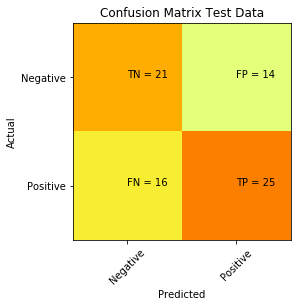

In [25]:
# confusion matrix plotting from https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/
plt.clf()
plt.imshow(conf_mat_logist, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf_mat_logist[i][j]))
plt.show()

Results: Using inductive bias I assigned a test size of 20% of my data set. Using this, method of analysis, we see an improvement on our intial 50% baseline. Recall that using the 190 maximum sample size showed that approximatly 50% of the time does the team with the better record win the series. Using the features clearly shown in the pandas table, we can predict games at approximatly a 61% accuracy. Pretty Good! However, we completely recognize this is statistically fragile as the test and training set are not as comprhensive as ideal. 

### Section 5: Analysis 2 of 2
##### In an attempt to improve on the results, we readjusted out method of analysis. The initial goal was to use home team performance as our target, however the data sources did not lend itself kindly to retreiving this data. Therefore, I wanted to analyize performance of team with a better record. Our classifier is thus not "Winning team had better record" vs. "Winning Team had worse record" (assigned value of 1 and 0 respectively). For simplistic sake, if the winning team had the same record as the losing team, that instance would be assigned a value of 0.  

In [21]:
cur.execute('SELECT * FROM Series')
#  series, winning, losing, year
results = cur.fetchall()
win = []
lose = []
target = []
for row in results:
    win.append((row[1],row[3]))
    lose.append((row[2],row[3]))
    target.append(row[4])
print(target)
print(win)

[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]
[(30, 2019), (11, 2019), (30, 2019), (11, 2019), (19, 2019), (30, 2019), (26, 2019), (27, 2019), (30, 2019), (4, 2018), (4, 2018), (14, 2018), (4, 2018), (11, 2018), (16, 2018), (14, 2018), (19, 2018), (9, 2018), (11, 2017), (11, 2017), (14, 2017), (19, 2017), (11, 2017), (14, 2017), (5, 2017), (19, 2017), (1, 2017), (5, 2016), (8, 2016), (5, 2016)]


In [22]:
def stat_retreival(winner, loser):
    try:
        cmd_line = "SELECT * FROM Stats WHERE team_id = %d and year = %d" % (winner)
        cur.execute(cmd_line)
        results_winner = cur.fetchall()
    except: 
        results_winner = 'NaN'
    
    try:
        cmd_line = "SELECT * FROM Stats WHERE team_id = %d and year = %d" % (loser)
        cur.execute(cmd_line)
        results_loser = cur.fetchall()
    except:
        results_loser = 'NaN'
        
   
    return (results_winner, results_loser)

In [23]:
logistic_reg_array2 = []
for i in range(len(win)):
    logistic_reg_array2.append([stat_retreival(win[i], lose[i]),target[i]])

The next few cells combines our API data with our fos sports team stat data

In [24]:
new_val_rbi = []
for row in val_rbi:
    cmd_line = "SELECT team_id FROM prim_ID WHERE API_ID = %d" % row[1]
    cur.execute(cmd_line)
    results_winner_flip = cur.fetchall()
    
    cmd_line = "SELECT team_id FROM prim_ID WHERE API_ID = %d" % row[3]
    cur.execute(cmd_line)
    results_loser_flip = cur.fetchall()
    new_val_rbi.append([row[0],results_winner_flip[0][0],row[2],results_loser_flip[0][0],row[4]])

# print(new_val_rbi)

[[2019, 30, 1373, 11, 1384], [2019, 11, 1380, 19, 1619], [2019, 30, 1373, 26, 1231], [2019, 11, 1416, 27, 1455], [2019, 19, 1628, 17, 1750], [2019, 30, 1373, 14, 1600], [2019, 26, 1231, 2, 0], [2019, 27, 1455, 20, 1418], [2019, 30, 1373, 16, 1417], [2018, 4, 1101, 14, 1257], [2018, 4, 1004, 11, 1359], [2018, 14, 1257, 16, 1328], [2018, 4, 1004, 19, 1448], [2018, 11, 1359, 8, 1166], [2018, 16, 1328, 9, 974], [2018, 14, 1257, 2, 0], [2018, 19, 1448, 20, 1294], [2018, 9, 1035, 5, 962], [2017, 11, 1190, 14, 953], [2017, 11, 1190, 19, 1441], [2017, 14, 953, 5, 997], [2017, 19, 1481, 8, 1334], [2017, 11, 1190, 4, 1410], [2017, 14, 953, 1, 1251], [2017, 5, 997, 30, 1043], [2017, 19, 1539, 17, 1484], [2017, 1, 1251, 9, 1224], [2016, 5, 1385, 8, 1380], [2016, 8, 1304, 29, 1159], [2016, 5, 1385, 14, 948]]


In [25]:
logistic_reg_array3 = []
for i in range(len(new_val_rbi)):
    if new_val_rbi[i][1] == logistic_reg_array2[i][0][0][0][0] and new_val_rbi[i][3] == logistic_reg_array2[i][0][1][0][0]:
        logistic_reg_array3.append([logistic_reg_array2[i],new_val_rbi[i][2],new_val_rbi[i][4]])

In [29]:
blank2 = []
counter = 0
for row in logistic_reg_array3:
#     print(row[0][1][0][2])
    try:
        blank2.append([row[0][0][0][0][1],row[0][0][0][0][0],row[0][0][0][0][2],row[0][0][0][0][3],row[0][0][0][0][4],\
                   row[0][0][0][0][5],row[0][0][0][0][6],row[0][0][0][0][7],row[1],row[0][0][1][0][0],row[0][0][1][0][2],\
                   row[0][0][1][0][3],row[0][0][1][0][4],row[0][0][1][0][5],row[0][0][1][0][6],row[0][0][1][0][7],row[2],\
                   row[0][1]])
    except:
        blank2.append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
    counter += 1
#     print(counter)

# print(blank2)

In [27]:
df2 = pd.DataFrame(np.array(blank2), columns=['year', 'winning team', 'winning team OBP','winning team SLG', 'winning team HR','winning team WHIP',
                               'winning team ERA','winning team SO9','winning team rbi','losing team', 'losing team OBP','losing team SLG', 'losing team HR','losing team WHIP',
                               'losing team ERA','losing team SO9','losing team rbi','Target'])
df2['diff OBP'] = df2['winning team OBP'] - df2['losing team OBP']
df2['diff SLG'] = df2['winning team SLG'] - df2['losing team SLG']
df2['diff HR'] = df2['winning team HR'] - df2['losing team HR']
df2['diff WHIP'] = df2['winning team WHIP'] - df2['losing team WHIP']
df2['diff ERA'] = df2['winning team ERA'] - df2['losing team ERA']
df2['diff SO9'] = df2['winning team SO9'] - df2['losing team SO9']
df2['diff RBI'] = df2['winning team rbi'] - df2['losing team rbi']
df2 = df2.dropna(thresh=1)

df2.head()

,year,winning team,winning team OBP,winning team SLG,winning team HR,winning team WHIP,winning team ERA,winning team SO9,winning team rbi,losing team,...,losing team SO9,losing team rbi,Target,diff OBP,diff SLG,diff HR,diff WHIP,diff ERA,diff SO9,diff RBI
0,2019.0,30.0,0.342,0.454,231.0,1.46,5.06,8.6,1373.0,11.0,...,7.9,1384.0,1.0,-0.010,-0.041,-57.0,-0.03,-0.50,0.7,-11.0
1,2019.0,11.0,0.352,0.495,288.0,1.49,5.56,7.9,1380.0,19.0,...,8.3,1619.0,1.0,0.024,0.053,46.0,0.06,0.77,-0.4,-239.0
2,2019.0,30.0,0.342,0.454,231.0,1.46,5.06,8.6,1373.0,26.0,...,9.5,1231.0,1.0,0.020,0.039,21.0,0.17,0.79,-0.9,142.0
3,2019.0,11.0,0.352,0.495,288.0,1.49,5.56,7.9,1416.0,27.0,...,10.0,1455.0,0.0,0.027,0.064,71.0,0.11,0.86,-2.1,-39.0
4,2019.0,19.0,0.328,0.442,242.0,1.43,4.79,8.3,1628.0,17.0,...,8.6,1750.0,1.0,-0.010,-0.052,-65.0,-0.03,-0.45,-0.3,-122.0


In [48]:
x_data2 = df2[['diff OBP','diff SLG', 'diff HR','diff WHIP','diff ERA','diff SO9','diff RBI']]
y_data2 = df2.Target
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data2, y_data2, test_size = 0.5, random_state = 12) #split the test and training sets
model = LogisticRegression()
model.fit(x_train, y_train)
prediction = dict()
prediction['Logistic'] = model.predict(x_test)
print('This model is accurate to: ',accuracy_score(y_test, prediction['Logistic']))
print(f'the weights for the features are: {model.coef_}') 
conf_mat_logist2 = confusion_matrix(y_test2, prediction['Logistic'])
# print('Logist \r', conf_mat_logist2)

This model is accurate to:  0.4666666666666667
the weights for the features are: [[ 0.02543677  0.03107281 -0.04735554  0.19393876  0.20225825 -1.13632932
  -0.00573305]]


C:\Users\Peter Argo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


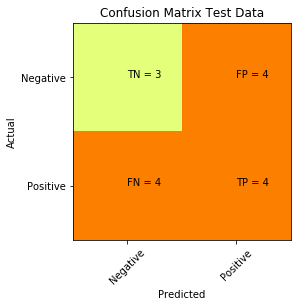

In [49]:
# confusion matrix plotting from https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/
plt.clf()
plt.imshow(conf_mat_logist2, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix Test Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf_mat_logist2[i][j]))
plt.show()

Results: I increased the test size partition because we are working with 50 samples as opposed to 190 as in analysis 1.  We see a 53% prediction accuracy however nothing can be concluded with only 50 samples.

# --------------------------------------------------------------------------------------------------------------